# Explore the data on UK employers claiming furlough in December 2020

HMRC has published the [list of UK employers who claimed through the CJRS (furlough) scheme](https://www.gov.uk/government/publications/employers-who-have-claimed-through-the-coronavirus-job-retention-scheme) during December 2020. We can join this with [Companies House basic company data](http://download.companieshouse.gov.uk/en_output.html) to learn more about the companies claiming furlough, including their incorporation dates, SICC codes and company structures.

Not all furlough recipients can be joined with their Companies House records, since the HMRC data only contains employer names (it will apparently have company numbers from next month). It uses the employer name that’s attached to the PAYE scheme, which only matches a Companies House name perfectly about two-thirds of the time. Still, this produces about half a million matches, enough to be interesting.

Suggested next step: join this with Companies House data on persons of significant control.

The notebook is published under CC-BY-SA: please attribute Anna Powell-Smith if you reuse any of this work.

In [ ]:
import csv
import os
import pandas as pd
import psycopg2
import re

This assumes you have the HMRC data saved locally.

In [ ]:
df = pd.read_csv("./data/Employer_claim_data_-_December_2020.csv")
print(len(df))
df.head()

## Join the HMRC furlough data with Companies House records, by name

Join the employer data with Companies House company records. We have to do this by name, since company numbers aren't currently in the published HMRC data (which uses the names recorded on PAYE returns).

This assumes: 

1. you have the latest Companies House records in a local Postgres database (it would be neater to do everything in pandas, but this is what I happened to have already)
2. that (i) company names are unique and (i) company names are unique even when LTD/LIMITED are substituted for each other. A quick query of the Companies House dataset suggests this is essentially true - there are about 1500 duplicate entries in a dataset of 4.8 million company names.

In [3]:
conn = psycopg2.connect("dbname=%s user=%s" % (os.environ['COHOUSE_DB'], os.environ['COHOUSE_DB_USER']))
cur = conn.cursor()

In [19]:
reader = csv.DictReader(open('./data/Employer_claim_data_-_December_2020.csv'))
writer = csv.writer(open("./data/joined_employers.csv", 'w'))
header = ["company_number", "company_name", "company_category", "company_status", "company_address",
         "country_of_origin", "dissolution_date", "incorporation_date",
          "sicc1", "sicc2", "sicc3", "sicc4", "previous_company1"]
writer.writerow(header)

query_str = ", ".join(header)
query = "SELECT %s from cohouse_company" % query_str
for row in reader:
    name = row['Employer Name']
    cur.execute(query + " where company_name=%(name)s", {"name": name})
    result = cur.fetchone()
    # Try substituting LTD/LIMITED (but no fuzzier matching than that).
    if not result:
        if name.endswith(" LTD"):
            name = re.sub(" LTD$", " LIMITED", name)
        elif name.endswith(" LIMITED"):
            name = re.sub(" LIMITED$", " LTD", name)
        cur.execute(query + " where company_name=%(name)s", {"name": name})
        result = cur.fetchone()
    if not result:
        result = ['' for i in range(0, 12)]
        result[1] = name
    writer.writerow(result)

In [20]:
df_joined = pd.read_csv("./data/joined_employers.csv")
df_joined.incorporation_date = pd.to_datetime(df_joined.incorporation_date)

In [24]:
df_joined.head()

,company_number,company_name,company_category,company_status,company_address,country_of_origin,dissolution_date,incorporation_date,sicc1,sicc2,sicc3,sicc4,previous_company1
0,12434675,& CO DESIGN LIMITED,Private Limited Company,Active,3 ANEURIN COTTAGES BAGILLT CH6 6BQ WALES,United Kingdom,NaN,2020-01-30,47710 - Retail sale of clothing in specialised...,NaN,NaN,NaN,NaN
1,NaN,& MEETINGS LTD,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,08697873,& NEW LIMITED,Private Limited Company,Active,19 WARREN PARK WAY LEICESTER LE19 4SA,United Kingdom,NaN,2013-09-19,"46470 - Wholesale of furniture, carpets and li...",NaN,NaN,NaN,NaN
3,06508401,& SMITH LIMITED,Private Limited Company,Active,19 ABBOTS BUSINESS PARK KINGS LANGLEY WD4 8FR ...,United Kingdom,NaN,2008-02-19,90030 - Artistic creation,NaN,NaN,NaN,NaN
4,10709533,& THE NEW ... LTD,Private Limited Company,Active,CAMBRIDGE HOUSE 27 CAMBRIDGE PARK LONDON E11 2...,United Kingdom,NaN,2017-04-05,73120 - Media representation services,NaN,NaN,NaN,NaN


Over a third of the companies in the HMRC data can't be joined to Companies House records purely by name, sigh. This will hopefully improve next month when company numbers are included in the data.

In [25]:
len(df_joined[~df_joined.company_number.isnull()])

507326

## Look at company structures

What types of company structure are being supported? The PLCs are probably the companies you've heard of.

In [26]:
df_joined.value_counts("company_category")

company_category
Private Limited Company                                                                      496607
PRI/LTD BY GUAR/NSC (Private, limited by guarantee, no share capital)                          3459
PRI/LBG/NSC (Private, Limited by guarantee, no share capital, use of 'Limited' exemption)      2832
Limited Liability Partnership                                                                  1274
Charitable Incorporated Organisation                                                            853
Community Interest Company                                                                      763
Registered Society                                                                              726
Public Limited Company                                                                          336
Other company type                                                                              174
Scottish Charitable Incorporated Organisation                                      

## Look at incorporation dates

There are quite a lot of companies claiming furlough that have only been incorporated since the start of the pandemic.

Lots of these will be legitimate, but others may be opportunists. (NB: closer inspection suggests that sometimes new companies are 'incorporated' when they're really a rename of an existing company, too.)

<AxesSubplot:title={'center':'Year and month of incorporation, for matched companies incorporated since 2018'}, xlabel='incorporation_date,incorporation_date'>

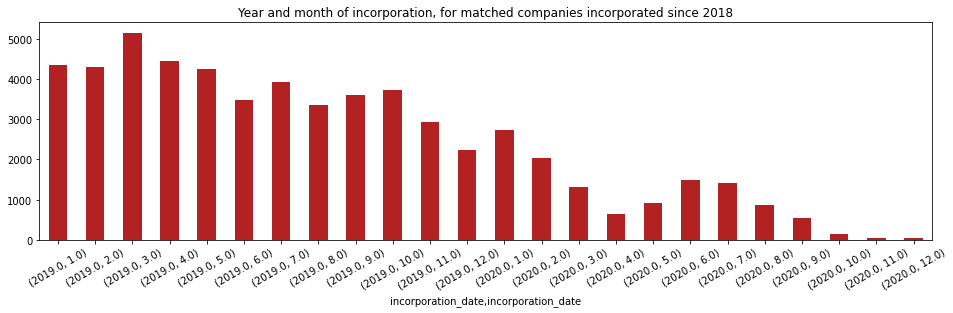

In [27]:
df_joined[df_joined.incorporation_date.dt.year > 2018]\
    .groupby([(df_joined.incorporation_date.dt.year),(df_joined.incorporation_date.dt.month)])\
    .company_number.count().plot(kind='bar', color='firebrick', rot=30, figsize=(16,4),
                                title="Year and month of incorporation, for matched companies incorporated since 2018")

There appear to be 6,300 companies using furlough whose incorporation date is after the start of the first UK lockdown.

In [28]:
len(df_joined[df_joined.incorporation_date > "2020-03-23"])

6300

A few have a 'previous company' field in Companies House, and googling others suggests that they may be renames of existing companies. 

In [30]:
len(df_joined[(df_joined.incorporation_date > "2020-03-23") & (df_joined.previous_company1.isnull())])

6124

In theory, a company can only claim furlough [if it created a PAYE scheme before 30 October 2020](https://www.gov.uk/guidance/claim-for-wage-costs-through-the-coronavirus-job-retention-scheme#who-can-claim) - but some of these companies weren't incorporated then. Surely you can't set up a PAYE scheme before you're incorporated?

This suggests either HMRC aren't doing basic checks, or something is wrong with the data somewhere.

Hm - if I google some of these companies it looks a lot of them have perhaps just been renamed, though without having a 'previous name' in the data (e.g. Beeronomy Ltd) but perhaps some really are new companies (e.g. Alakai Ltd).

This should all get a lot easier to analyse when HMRC include company numbers in the data from next month.

In [37]:
df_setup_since_nov = df_joined[(df_joined.incorporation_date > "2020-11-01") & (df_joined.previous_company1.isnull())]
print(len(df_setup_since_nov))

66


## Look at SICC codes

SICC codes tell us what the company does (as judged by the directors of the company). They are a rough and not especially useful indicator of a company's real activity, but may show us some useful lines of inquiry.

There are high counts for hairdressers, restaurants, pubs etc as we'd expect. A notable code in the top 30 is "Other letting and operating of own or leased real estate" - this is often used for companies that are tax-efficient wrappers around buy-to-let properties.

In [38]:
df_joined.value_counts("sicc1").head(30)

sicc1
82990 - Other business support service activities n.e.c.                                       25319
70229 - Management consultancy activities other than financial management                      18149
96090 - Other service activities n.e.c.                                                        17518
56101 - Licensed restaurants                                                                   15885
96020 - Hairdressing and other beauty treatment                                                15125
62020 - Information technology consultancy activities                                          11792
56302 - Public houses and bars                                                                 10585
49410 - Freight transport by road                                                              10160
56102 - Unlicensed restaurants and cafes                                                        8593
56103 - Take-away food shops and mobile food stands                                  